# Import Necessary Modules

In [1]:
import struct
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Activation, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load the 'Fashion MNIST' Dataset & Examine it
Download the Fashion MNIST dataset from https://www.kaggle.com/datasets/zalando-research/fashionmnist

In [2]:
# Define a function that will read idx file format as numpy arrays
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [3]:
# Load the Fashion MNIST dataset & split it into training and validation datasets
x_train = read_idx("./Dataset/train-images-idx3-ubyte")
y_train = read_idx("./Dataset/train-labels-idx1-ubyte")
x_val = read_idx("./Dataset/t10k-images-idx3-ubyte")
y_val = read_idx("./Dataset/t10k-labels-idx1-ubyte")

# Some print statements to examine the dataset we have
print("Number of samples in our training data: " + str(len(x_train)))
print("Number of labels in our training data: " + str(len(y_train)))
print("Number of samples in our validation data: " + str(len(x_val)))
print("Number of labels in our validation data: " + str(len(y_val)))
print()
print("Dimensions of x_train: " + str(x_train.shape))
print("Dimensions of x_val: " + str(x_val.shape))

Number of samples in our training data: 60000
Number of labels in our training data: 60000
Number of samples in our validation data: 10000
Number of labels in our validation data: 10000

Dimensions of x_train: (60000, 28, 28)
Dimensions of x_val: (10000, 28, 28)


# Preprocessing Our Dataset

## Preprocessing our image datasets i.e x_train & x_val

In [4]:
# Add a fourth column that indicates number of channels of the images present within the dataset
x_train = x_train.reshape(60000, 28, 28, 1)
x_val = x_val.reshape(10000, 28, 28, 1)

# Change our image data type to float32 data type
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

# Normalize our data by changing the range from (0 to 255) to (0 to 1)
x_train /= 255
x_val /= 255

## Preprocessing our label datasets i.e y_train & y_val

In [5]:
# Since we are dealing with categorical data, we need to 'One-Hot' encode our labels
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)

# Build a Model

## Create the Model

In [6]:
# Initalize the model using Sequential class from Keras
model = Sequential()
# Add first convolutional layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(28, 28, 1), padding="same"))
# Add a batch normalization layer that will standardize and normalize the input values
model.add(BatchNormalization())
# Add an activation layer that will introduce non-linearity to our input
model.add(Activation('relu'))
# Add a pooling layer which will downsample our data
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add 2nd convolutional layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same"))
# Add a batch normalization layer that will standardize and normalize the input values
model.add(BatchNormalization())
# Add an activation layer that will introduce non-linearity to our input
model.add(Activation('relu'))
# Add a pooling layer which will downsample our data
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a flatten layer which will aid in flattening the input
model.add(Flatten())
# Add a dense/FC layer
model.add(Dense(units=256, activation='relu'))
# Add a dense/FC layer
model.add(Dense(units=10, activation='softmax'))
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
# Print a summary of our model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0

## Define Callbacks

In [7]:
# Define a callback for saving only the best model during the training
checkpoint = ModelCheckpoint(filepath="./Trained Models/fashion_mnist_clothing_classifier.h5",
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

# Define a callback to stop training when validation accuracy has stopped increasing
earlystop = EarlyStopping(monitor='val_accuracy',
                          mode='max',
                          patience=5,
                          restore_best_weights=True,
                          verbose=1)

# Put our callbacks into a list
callbacks = [earlystop, checkpoint]

# Train the Model

In [8]:
# Train our model and store the training results in a variable
model_train_result = model.fit(x=x_train,
                               y=y_train,
                               batch_size=32,
                               epochs=100,
                               callbacks=callbacks,
                               verbose=1,
                               validation_data=(x_val, y_val))

Epoch 1/100
1875/1875 [==============================] - 12s 5ms/step - loss: 0.5383 - accuracy: 0.8206 - val_loss: 0.2979 - val_accuracy: 0.8903

Epoch 00001: val_accuracy improved from -inf to 0.89030, saving model to ./Trained Models\fashion_mnist_clothing_classifier.h5
Epoch 2/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2648 - accuracy: 0.9021 - val_loss: 0.2674 - val_accuracy: 0.9036

Epoch 00002: val_accuracy improved from 0.89030 to 0.90360, saving model to ./Trained Models\fashion_mnist_clothing_classifier.h5
Epoch 3/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2243 - accuracy: 0.9179 - val_loss: 0.2423 - val_accuracy: 0.9129

Epoch 00003: val_accuracy improved from 0.90360 to 0.91290, saving model to ./Trained Models\fashion_mnist_clothing_classifier.h5
Epoch 4/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1872 - accuracy: 0.9297 - val_loss: 0.2419 - val_accuracy: 0.9107

Epoch 00004: val_accuracy di

# Evaluate Model's Performance

## Loss & Accuracy Charts

### Loss Chart

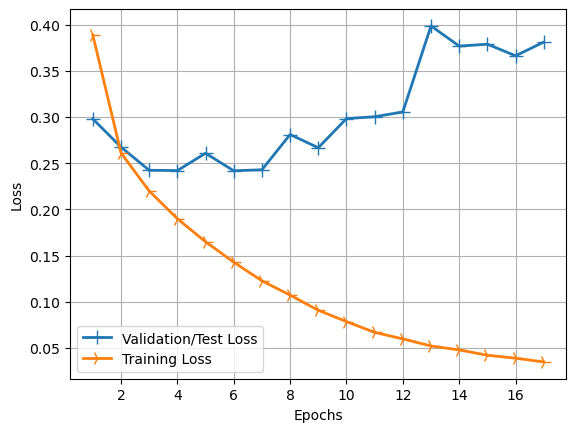

In [9]:
history_dict = model_train_result.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

### Accuracy chart

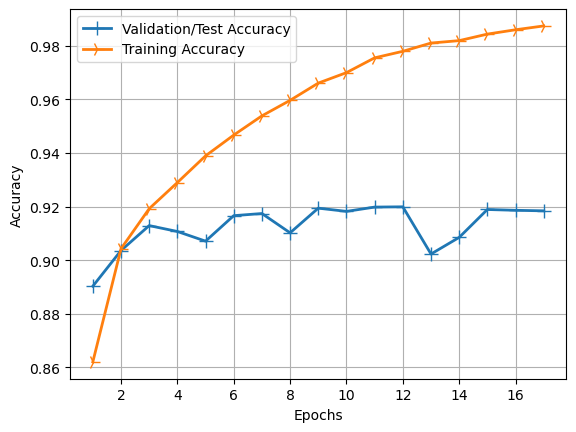

In [10]:
history_dict = model_train_result.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## Classification Report for Validation Dataset

In [11]:
# Undo the one-hot encoding for y_val
y_val = np.argmax(y_val, axis=1)

# Get model's predictions for each image in validation dataset
val_pred = model.predict(x_val, batch_size=32)

# Undo the one-hot encoding for val_pred
val_pred = np.argmax(val_pred, axis=1)

# Get class names
class_names = np.array(['0', '1', '2',
                        '3', '4', '5', '6', '7', '8', '9'])

# Get the classification report generated for validation dataset
print(classification_report(y_true=y_val,
                            y_pred=val_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.84      0.90      0.87      1000
           3       0.92      0.91      0.92      1000
           4       0.88      0.87      0.87      1000
           5       0.99      0.99      0.99      1000
           6       0.80      0.74      0.77      1000
           7       0.96      0.98      0.97      1000
           8       0.98      0.99      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



## Confusion Matrix for Validation Dataset

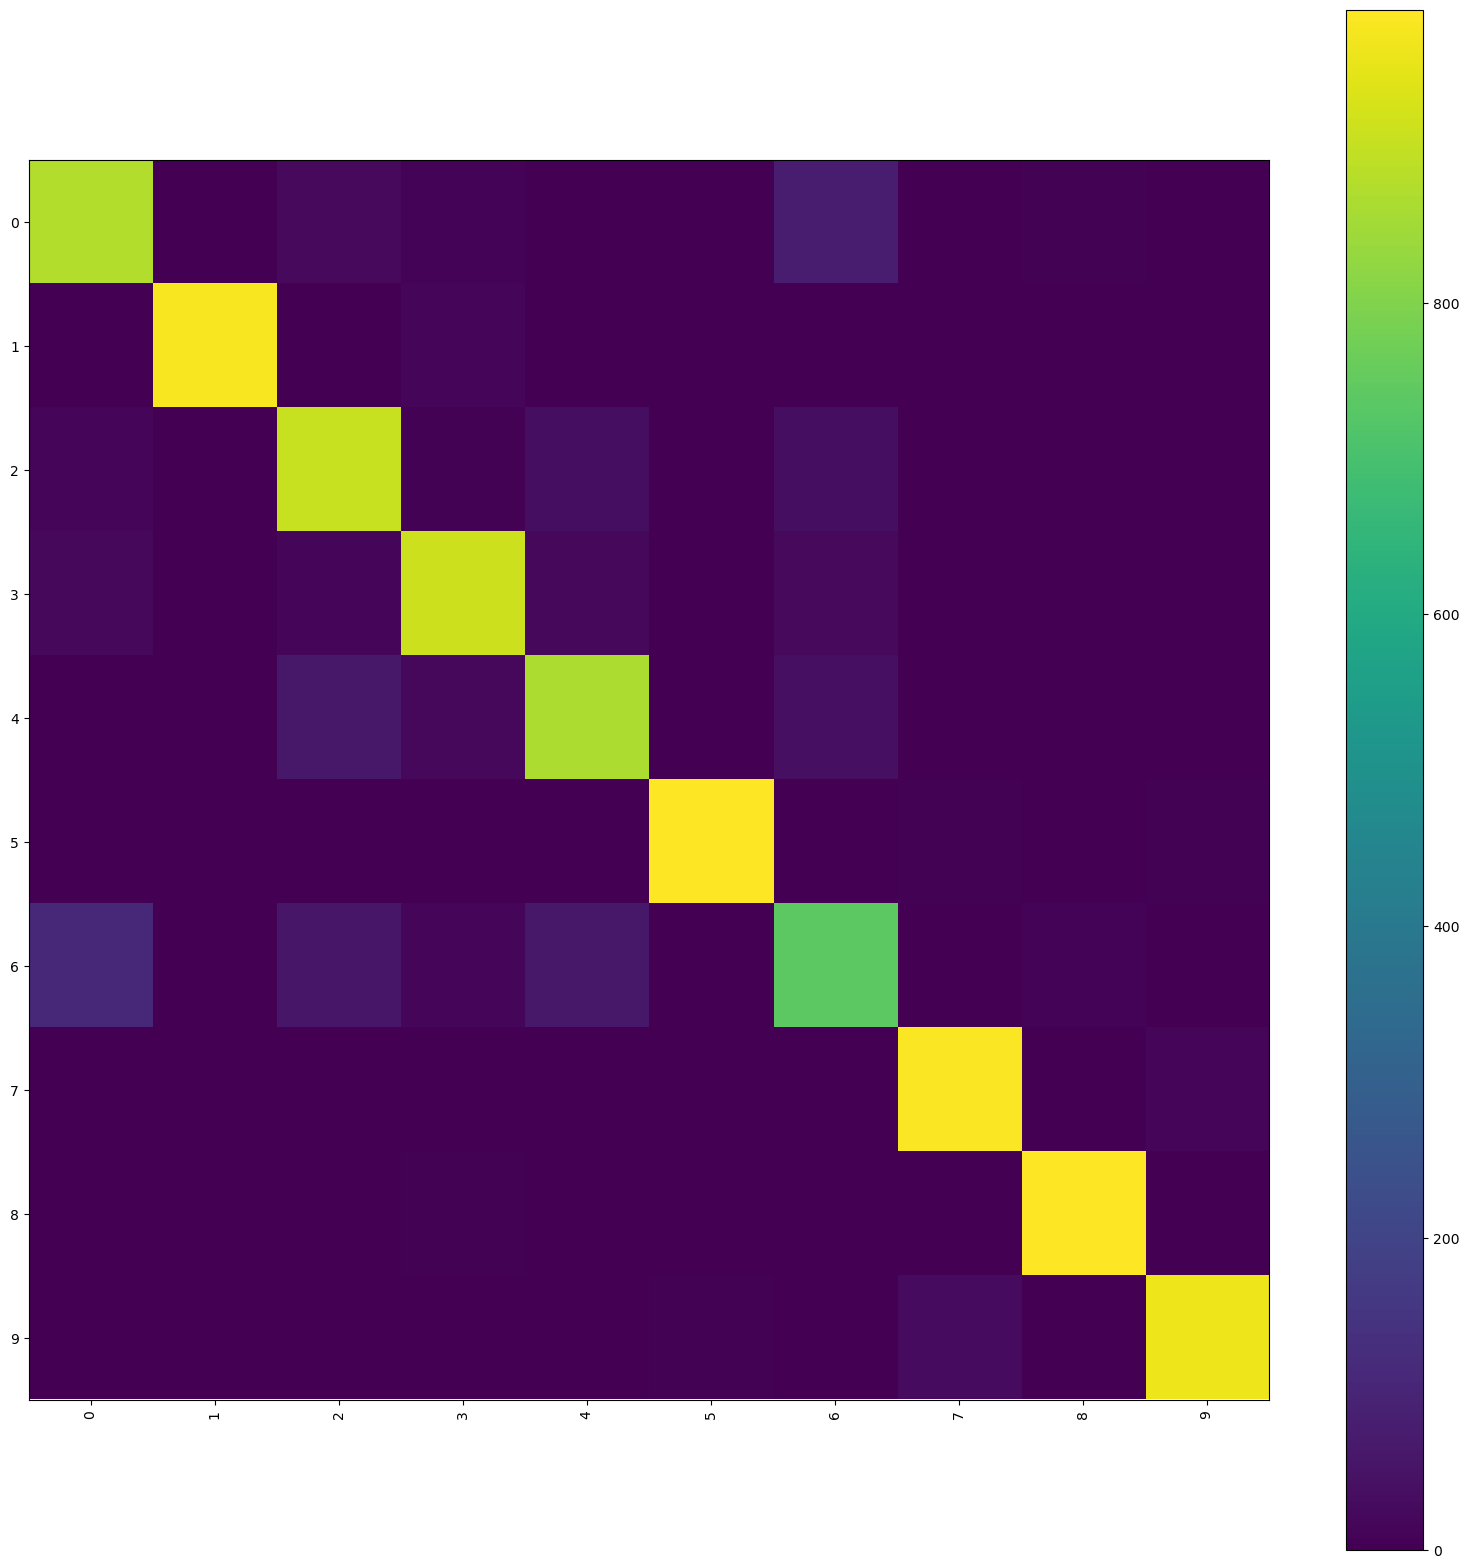

In [12]:
# Generate the confusion matrix for validation dataset
cnf_matrix = confusion_matrix(y_true=y_val, y_pred=val_pred)

# Display the confusion matrix
plt.figure(figsize=(20, 20))
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(class_names))
_ = plt.xticks(tick_marks, class_names, rotation=90)
_ = plt.yticks(tick_marks, class_names)
plt.show()

# Classifier Demonstration

## Define Required Functions

In [13]:
def get_label(input_class):
    number = int(input_class)
    if number == 0:
        return "T-shirt/top "
    if number == 1:
        return "Trouser"
    if number == 2:
        return "Pullover"
    if number == 3:
        return "Dress"
    if number == 4:
        return "Coat"
    if number == 5:
        return "Sandal"
    if number == 6:
        return "Shirt"
    if number == 7:
        return "Sneaker"
    if number == 8:
        return "Bag"
    if number == 9:
        return "Ankle boot"


def draw_test(name, pred, actual, input_im):
    black = [0, 0, 0]
    res = get_label(pred)
    actual = get_label(actual)
    expanded_image = cv2.copyMakeBorder(
        input_im, 0, 0, 0, 4*imageL.shape[0], cv2.BORDER_CONSTANT, value=black)
    expanded_image = cv2.cvtColor(expanded_image, cv2.COLOR_GRAY2BGR)
    cv2.putText(expanded_image, "Predicted - " + str(res), (152, 70),
                cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0), 1)
    cv2.putText(expanded_image, "   Actual - " + str(actual),
                (152, 90), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)
    cv2.imshow(name, expanded_image)

## Run the Demonstration

In [17]:
for i in range(0, 10):
    rand = np.random.randint(0, len(x_val))
    input_im = x_val[rand]
    actual = y_val[rand]
    imageL = cv2.resize(input_im, None, fx=4, fy=4,
                        interpolation=cv2.INTER_CUBIC)
    input_im = input_im.reshape(1, 28, 28, 1)
    res = str(np.argmax(model.predict(input_im), axis=-1)[0])
    draw_test("Prediction", res, actual, imageL)
    cv2.waitKey(0)

cv2.destroyAllWindows()